**US Stock price forecasting  using deep Neural Networks**

*Disclaimer*: 

This is not how trading works. Although the results of this work are very promising for the task of forecasting the future price of a single stock, the keen reader should bear the following fact in their mind. Successful trading is all about balancing portfolios and minimizing the risk. A Machine Learning practitioner should try to find and buy undervalued securities  (stocks, bonds, and such) and sell the overpriced ones.

Efforts are made towards the longterm (365-day) prediction of the close price index of DOW Jones Industrial index, using a 3-year window form 2016 to 2019. This is a very interesting choice of data since it can put our ML algorithm to the test. In this window, during the test period, the index mostly shows an upward trend. There however exists a sudden drop In the test part. Its shown that a combination of a convolution layer (to capture the patterns) and LSTM layers  (for the sake of long memory) does a phenomenal job and the model is able to accurately predict the 9-day moving average graph. 

In [1]:
#data acquisition modules 
import pandas_datareader.data as pdr
import yfinance as fix
import time
import datetime
# general modules 
import pandas as pd
pd.options.display.max_rows = 10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
import os
# Deep Learning modules 
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras import metrics
from keras.layers import LSTM, Dense, Activation
import h5py
#sklearn and xgboost
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
def stock_data_unpack(ticker, start_date, end_date):
    count = 0
    try:
        raw_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    except ValueError:
        print("ValueError, trying again")
        count += 1
        if count < 9:
            time.sleep(random.randrange(10))
            get_stock_data(ticker, start_date, end_date)
        else:
            print("Yahoo error. I will Try in a second or so")
            time.sleep(range(10,60))
            get_stock_data(ticker, start_date, end_date) 
            
    stock_data = raw_data 
    stock_data.to_csv("raw_data.csv")

Let's read the DOW data from Yahoo and turn it into a Pandas DataFrame.

In [3]:
start = datetime(2016,9,11)
end =   datetime(2019,9,27)
seq_len = 1 
stock_data_unpack("^DJI", start_date=start, end_date=end)
df1=pd.read_csv("raw_data.csv", names=['Date','High','Low','Open','Close','Volume','Adj Close'], parse_dates=True)
df1=df1.rename(columns={'Open': 'Dow_Open', 'Close': 'Dow_Close','Volume': 'Dow_Volume','High': 'Dow_High','Low': 'Dow_Low'})
df1=df1.drop(['Adj Close'],axis=1)
df1=df1.drop([0], axis=0)

In [4]:
df1.head()

,Date,Dow_High,Dow_Low,Dow_Open,Dow_Close,Dow_Volume
1,2016-09-12,18358.689453125,17994.83984375,18028.94921875,18325.0703125,103260000
2,2016-09-13,18262.990234375,18028.060546875,18262.990234375,18066.75,102830000
3,2016-09-14,18163.48046875,17992.2109375,18073.390625,18034.76953125,103360000
4,2016-09-15,18250.109375,18015.490234375,18024.91015625,18212.48046875,99550000
5,2016-09-16,18217.2109375,18070.2109375,18217.2109375,18123.80078125,278510000


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time index")
    plt.ylabel("Price Index")
    plt.grid(True)
def moving_average(t, window):
    return np.convolve(t, np.ones(window), 'valid') / window

The above helper functions help us with plotting and calculating moving average (MA) plots. Furthermore, we normalize the variable for the luxury of numerical convergence.

In [6]:
series = df1['Dow_Close'].to_numpy().astype(float)
time = df1.index.values.astype(float)

maxval=np.max(series)
print('The maximum price is=',maxval)
series=series/maxval
maxT=np.max(time)
print('The number of simulated days is=',maxT)
time=time/maxT

The maximum price is= 27359.16015625
The number of simulated days is= 767.0


Very well! Let's visuals the time series and also plot a 9-day MA (an important indicator in the trading world).

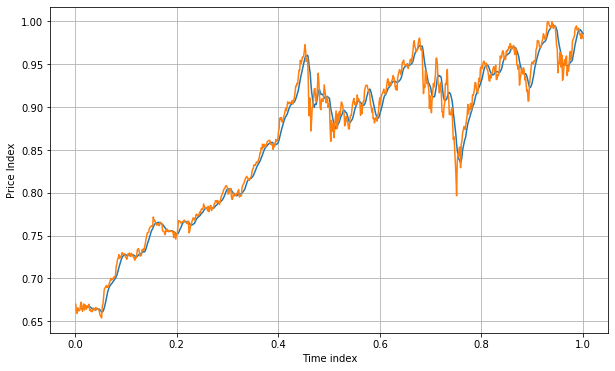

In [7]:
plt.figure(figsize=(10, 6))
window=9
plot_series(time[window-1:], moving_average(series,window))
plot_series(time, series)


The MA plot (in blue) filters out most of the white noise. Next, we split our data into train and test sets.

In [8]:
split_time = 365
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 40#64 This parameter affects the results greatly as it will be seen
batch_size = 8
shuffle_buffer_size = 1000

In [9]:
print(tf.__version__)

2.0.0-dev20191002


In [10]:
#If the version is less than 2, activate and run the following line
#!pip install tf-nightly-2.0-preview

**RNN parameter tunning**

In [9]:
def windowed_datasetII(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Let's start with a call back for the learning rate. To find the best loss function, we repeat the process for three loss functions. Our network has an initial convolution layer, followed by two bidirectional LSTM layers.  

In [16]:
#------------------------------------------------
# Huber Loss
#------------------------------------------------
tf.keras.backend.clear_session()

train_set = windowed_datasetII(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history1 = model1.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

#------------------------------------------------
# MAE loss
#------------------------------------------------
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=["mae"])
history2 = model2.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

#------------------------------------------------
#     MSE loss
#------------------------------------------------
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model3.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history3 = model3.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

Epoch 1/100
41/41 - 4s - loss: 0.2463 - mae: 0.6986
Epoch 2/100
41/41 - 1s - loss: 0.2451 - mae: 0.6969
Epoch 3/100
41/41 - 1s - loss: 0.2437 - mae: 0.6949
Epoch 4/100
41/41 - 1s - loss: 0.2423 - mae: 0.6926
Epoch 5/100
41/41 - 1s - loss: 0.2404 - mae: 0.6900
Epoch 6/100
41/41 - 1s - loss: 0.2386 - mae: 0.6872
Epoch 7/100
41/41 - 1s - loss: 0.2366 - mae: 0.6840
Epoch 8/100
41/41 - 1s - loss: 0.2338 - mae: 0.6805
Epoch 9/100
41/41 - 1s - loss: 0.2308 - mae: 0.6765
Epoch 10/100
41/41 - 1s - loss: 0.2282 - mae: 0.6721
Epoch 11/100
41/41 - 1s - loss: 0.2246 - mae: 0.6672
Epoch 12/100
41/41 - 1s - loss: 0.2214 - mae: 0.6618
Epoch 13/100
41/41 - 1s - loss: 0.2174 - mae: 0.6557
Epoch 14/100
41/41 - 1s - loss: 0.2126 - mae: 0.6489
Epoch 15/100
41/41 - 1s - loss: 0.2080 - mae: 0.6414
Epoch 16/100
41/41 - 1s - loss: 0.2028 - mae: 0.6330
Epoch 17/100
41/41 - 1s - loss: 0.1970 - mae: 0.6238
Epoch 18/100
41/41 - 1s - loss: 0.1905 - mae: 0.6136
Epoch 19/100
41/41 - 1s - loss: 0.1839 - mae: 0.6023
Ep

Epoch 56/100
41/41 - 1s - loss: 0.0801 - mae: 0.0800
Epoch 57/100
41/41 - 1s - loss: 0.0739 - mae: 0.0739
Epoch 58/100
41/41 - 1s - loss: 0.0725 - mae: 0.0725
Epoch 59/100
41/41 - 1s - loss: 0.0691 - mae: 0.0692
Epoch 60/100
41/41 - 1s - loss: 0.0659 - mae: 0.0659
Epoch 61/100
41/41 - 1s - loss: 0.0645 - mae: 0.0646
Epoch 62/100
41/41 - 1s - loss: 0.0607 - mae: 0.0607
Epoch 63/100
41/41 - 1s - loss: 0.0644 - mae: 0.0644
Epoch 64/100
41/41 - 1s - loss: 0.0581 - mae: 0.0582
Epoch 65/100
41/41 - 1s - loss: 0.0604 - mae: 0.0601
Epoch 66/100
41/41 - 1s - loss: 0.0592 - mae: 0.0593
Epoch 67/100
41/41 - 1s - loss: 0.0556 - mae: 0.0556
Epoch 68/100
41/41 - 1s - loss: 0.0553 - mae: 0.0553
Epoch 69/100
41/41 - 1s - loss: 0.0486 - mae: 0.0487
Epoch 70/100
41/41 - 1s - loss: 0.0549 - mae: 0.0549
Epoch 71/100
41/41 - 1s - loss: 0.0432 - mae: 0.0431
Epoch 72/100
41/41 - 1s - loss: 0.0568 - mae: 0.0568
Epoch 73/100
41/41 - 1s - loss: 0.0493 - mae: 0.0491
Epoch 74/100
41/41 - 1s - loss: 0.0494 - mae: 

(0, 0.1)

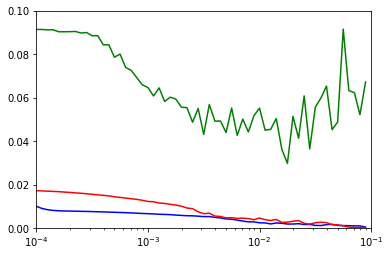

In [17]:
plt.semilogx(history1.history["lr"], history1.history["loss"],'b')
plt.semilogx(history2.history["lr"], history2.history["loss"],'g')
plt.semilogx(history3.history["lr"], history3.history["loss"],'r')
plt.xlim([1e-4,1e-1])
plt.ylim([0,1e-1])

The loss function "MeanSquaredError" shows the greatest promise with a learning rate of $5*e-3$.
Let's run it.

In [18]:
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)
])

optimizer = tf.keras.optimizers.SGD(lr=5*1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
41/41 [==============================] - 4s 97ms/step - loss: 0.0662 - mae: 0.1969
Epoch 2/500
41/41 [==============================] - 1s 28ms/step - loss: 0.0123 - mae: 0.0881
Epoch 3/500
41/41 [==============================] - 1s 26ms/step - loss: 0.0082 - mae: 0.0692
Epoch 4/500
41/41 [==============================] - 1s 28ms/step - loss: 0.0076 - mae: 0.0684
Epoch 5/500
41/41 [==============================] - 1s 27ms/step - loss: 0.0071 - mae: 0.0664
Epoch 6/500
41/41 [==============================] - 1s 28ms/step - loss: 0.0073 - mae: 0.0677
Epoch 7/500
41/41 [==============================] - 1s 29ms/step - loss: 0.0062 - mae: 0.0644
Epoch 8/500
41/41 [==============================] - 1s 30ms/step - loss: 0.0063 - mae: 0.0661
Epoch 9/500
41/41 [==============================] - 1s 29ms/step - loss: 0.0059 - mae: 0.0628
Epoch 10/500
41/41 [==============================] - 1s 28ms/step - loss: 0.0065 - mae: 0.0673
Epoch 11/500
41/41 [=============================

41/41 [==============================] - 1s 27ms/step - loss: 1.6532e-04 - mae: 0.0088
Epoch 167/500
41/41 [==============================] - 1s 30ms/step - loss: 1.6311e-04 - mae: 0.0088
Epoch 168/500
41/41 [==============================] - 1s 26ms/step - loss: 1.6057e-04 - mae: 0.0087
Epoch 169/500
41/41 [==============================] - ETA: 0s - loss: 1.6034e-04 - mae: 0.008 - 1s 26ms/step - loss: 1.6147e-04 - mae: 0.0087
Epoch 170/500
41/41 [==============================] - 1s 26ms/step - loss: 1.5917e-04 - mae: 0.0087
Epoch 171/500
41/41 [==============================] - 1s 34ms/step - loss: 1.5990e-04 - mae: 0.0086: 0s - loss: 1.2310e-04 
Epoch 172/500
41/41 [==============================] - 1s 30ms/step - loss: 1.5768e-04 - mae: 0.0086
Epoch 173/500
41/41 [==============================] - 1s 28ms/step - loss: 1.5706e-04 - mae: 0.0085
Epoch 174/500
41/41 [==============================] - 1s 29ms/step - loss: 1.5574e-04 - mae: 0.0085
Epoch 175/500
41/41 [==================

41/41 [==============================] - 1s 29ms/step - loss: 1.2048e-04 - mae: 0.0075
Epoch 324/500
41/41 [==============================] - 1s 28ms/step - loss: 1.2084e-04 - mae: 0.0075
Epoch 325/500
41/41 [==============================] - 1s 29ms/step - loss: 1.2054e-04 - mae: 0.0075
Epoch 326/500
41/41 [==============================] - 1s 28ms/step - loss: 1.2034e-04 - mae: 0.0075
Epoch 327/500
41/41 [==============================] - 1s 28ms/step - loss: 1.2093e-04 - mae: 0.0075
Epoch 328/500
41/41 [==============================] - 1s 28ms/step - loss: 1.2055e-04 - mae: 0.0075
Epoch 329/500
41/41 [==============================] - 1s 28ms/step - loss: 1.2029e-04 - mae: 0.0075
Epoch 330/500
41/41 [==============================] - 1s 29ms/step - loss: 1.1920e-04 - mae: 0.0075
Epoch 331/500
41/41 [==============================] - 1s 31ms/step - loss: 1.1921e-04 - mae: 0.0075
Epoch 332/500
41/41 [==============================] - 1s 30ms/step - loss: 1.1945e-04 - mae: 0.0075
Epoc

41/41 [==============================] - 1s 24ms/step - loss: 9.4215e-05 - mae: 0.0066
Epoch 484/500
41/41 [==============================] - 1s 25ms/step - loss: 9.4741e-05 - mae: 0.0066
Epoch 485/500
41/41 [==============================] - 1s 30ms/step - loss: 9.4007e-05 - mae: 0.0066
Epoch 486/500
41/41 [==============================] - 1s 30ms/step - loss: 9.3752e-05 - mae: 0.0066
Epoch 487/500
41/41 [==============================] - 1s 25ms/step - loss: 9.4081e-05 - mae: 0.0066
Epoch 488/500
41/41 [==============================] - 1s 24ms/step - loss: 9.3348e-05 - mae: 0.0066
Epoch 489/500
41/41 [==============================] - 1s 24ms/step - loss: 9.3698e-05 - mae: 0.0066
Epoch 490/500
41/41 [==============================] - 1s 32ms/step - loss: 9.2532e-05 - mae: 0.0066
Epoch 491/500
41/41 [==============================] - 1s 35ms/step - loss: 9.2681e-05 - mae: 0.0066
Epoch 492/500
41/41 [==============================] - 1s 32ms/step - loss: 9.3471e-05 - mae: 0.0066
Epoc

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

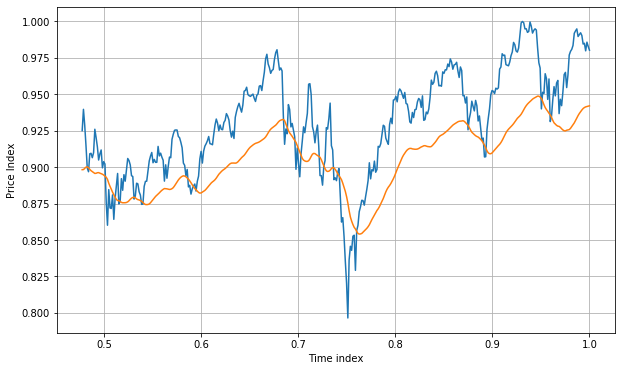

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Not bad! The dynamics of the system are captured. But the existence of rooms for improvement is undeniable. 
Let's use the same number of neurons but arrange them in a deeper network .

In [12]:
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)
])

optimizer = tf.keras.optimizers.SGD(lr=5*1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
41/41 [==============================] - 11s 257ms/step - loss: 0.0702 - mae: 0.1979
Epoch 2/500
41/41 [==============================] - 5s 112ms/step - loss: 0.0098 - mae: 0.0785
Epoch 3/500
41/41 [==============================] - 4s 105ms/step - loss: 0.0072 - mae: 0.0687
Epoch 4/500
41/41 [==============================] - 5s 111ms/step - loss: 0.0067 - mae: 0.0671
Epoch 5/500
41/41 [==============================] - 5s 113ms/step - loss: 0.0061 - mae: 0.0642
Epoch 6/500
41/41 [==============================] - 5s 123ms/step - loss: 0.0062 - mae: 0.0648
Epoch 7/500
41/41 [==============================] - 5s 111ms/step - loss: 0.0053 - mae: 0.0602
Epoch 8/500
41/41 [==============================] - 4s 104ms/step - loss: 0.0053 - mae: 0.0601
Epoch 9/500
41/41 [==============================] - 4s 108ms/step - loss: 0.0064 - mae: 0.0668
Epoch 10/500
41/41 [==============================] - 4s 98ms/step - loss: 0.0057 - mae: 0.0628
Epoch 11/500
41/41 [===================

41/41 [==============================] - 5s 116ms/step - loss: 2.6179e-04 - mae: 0.0110
Epoch 167/500
41/41 [==============================] - 5s 128ms/step - loss: 2.6020e-04 - mae: 0.0110
Epoch 168/500
41/41 [==============================] - 5s 124ms/step - loss: 2.5747e-04 - mae: 0.0109
Epoch 169/500
41/41 [==============================] - 6s 137ms/step - loss: 2.5245e-04 - mae: 0.0108
Epoch 170/500
41/41 [==============================] - 6s 141ms/step - loss: 2.5212e-04 - mae: 0.0109
Epoch 171/500
41/41 [==============================] - 5s 110ms/step - loss: 2.4963e-04 - mae: 0.0107
Epoch 172/500
41/41 [==============================] - 5s 114ms/step - loss: 2.4370e-04 - mae: 0.0107
Epoch 173/500
41/41 [==============================] - 5s 128ms/step - loss: 2.4281e-04 - mae: 0.0107
Epoch 174/500
41/41 [==============================] - 5s 111ms/step - loss: 2.3831e-04 - mae: 0.0106
Epoch 175/500
41/41 [==============================] - 4s 103ms/step - loss: 2.3945e-04 - mae: 0

41/41 [==============================] - 5s 122ms/step - loss: 7.6796e-05 - mae: 0.0062
Epoch 323/500
41/41 [==============================] - 4s 99ms/step - loss: 7.6456e-05 - mae: 0.0062
Epoch 324/500
41/41 [==============================] - 4s 91ms/step - loss: 7.6264e-05 - mae: 0.0063
Epoch 325/500
41/41 [==============================] - 4s 102ms/step - loss: 7.5408e-05 - mae: 0.0062
Epoch 326/500
41/41 [==============================] - 5s 120ms/step - loss: 7.5820e-05 - mae: 0.0063
Epoch 327/500
41/41 [==============================] - 4s 98ms/step - loss: 7.5024e-05 - mae: 0.0062
Epoch 328/500
41/41 [==============================] - 4s 93ms/step - loss: 7.6191e-05 - mae: 0.0062: 0s - loss: 7.1516e-05 - mae: 0.0
Epoch 329/500
41/41 [==============================] - 4s 108ms/step - loss: 7.5680e-05 - mae: 0.0062
Epoch 330/500
41/41 [==============================] - 4s 107ms/step - loss: 7.5512e-05 - mae: 0.0062
Epoch 331/500
41/41 [==============================] - 4s 101ms/st

41/41 [==============================] - 5s 115ms/step - loss: 6.7105e-05 - mae: 0.0059
Epoch 479/500
41/41 [==============================] - 5s 112ms/step - loss: 6.7971e-05 - mae: 0.0059
Epoch 480/500
41/41 [==============================] - 5s 118ms/step - loss: 6.7333e-05 - mae: 0.0059
Epoch 481/500
41/41 [==============================] - 5s 120ms/step - loss: 6.7451e-05 - mae: 0.0059
Epoch 482/500
41/41 [==============================] - 6s 136ms/step - loss: 6.8219e-05 - mae: 0.0059
Epoch 483/500
41/41 [==============================] - 5s 133ms/step - loss: 6.6760e-05 - mae: 0.0059
Epoch 484/500
41/41 [==============================] - 4s 102ms/step - loss: 6.6269e-05 - mae: 0.0059
Epoch 485/500
41/41 [==============================] - 4s 106ms/step - loss: 6.6852e-05 - mae: 0.0059
Epoch 486/500
41/41 [==============================] - 4s 108ms/step - loss: 6.6154e-05 - mae: 0.0059
Epoch 487/500
41/41 [==============================] - 4s 100ms/step - loss: 6.6641e-05 - mae: 0

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

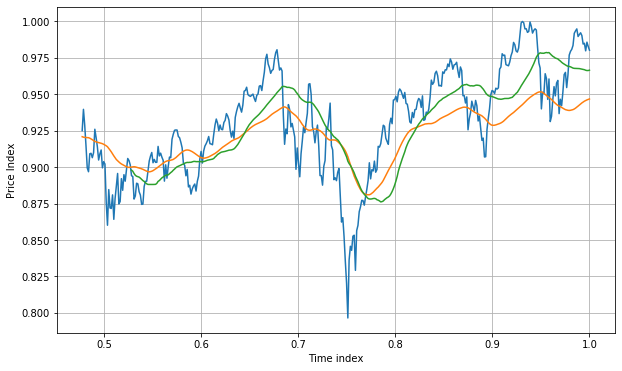

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
window=40
plot_series(time_valid[window-1:], moving_average(x_valid,window))

The network surely behaved more poorly. Clearly, our model has predicted the 40-day MA chart. Note that our chosen window was 40 days and it seems that reducing the window increase the accuracy. This makes statistical sense because the latest data have stronger autocorrelation with future events. As 9-day MA is an important indicator in the financial world, lets chose a window of 10 days.

In [20]:
split_time = 365
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 10# was 64
batch_size = 8
shuffle_buffer_size = 500 #100

Furthermore, it seems that having more neurons in the LSTM is more helpful than having multiple LSTM layers of a few neurons.  

In [41]:
from keras.callbacks import ModelCheckpoint

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<0.008):
            print("\nReached reasonable accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=window_size, kernel_size=2,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128*window_size, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64*window_size, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)
])
model.load_weights("weights.first.hdf5")
optimizer = tf.keras.optimizers.SGD(lr=1*1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
# checkpoint

filepath="weights.first.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='mae', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
history = model.fit(dataset,epochs=1,callbacks=callbacks_list)

     45/Unknown - 34s 758ms/step - loss: 7.7807e-05 - mae: 0.0055
Epoch 00001: saving model to weights.best.hdf5
45/45 [==============================] - 34s 765ms/step - loss: 7.7807e-05 - mae: 0.0055


In [42]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

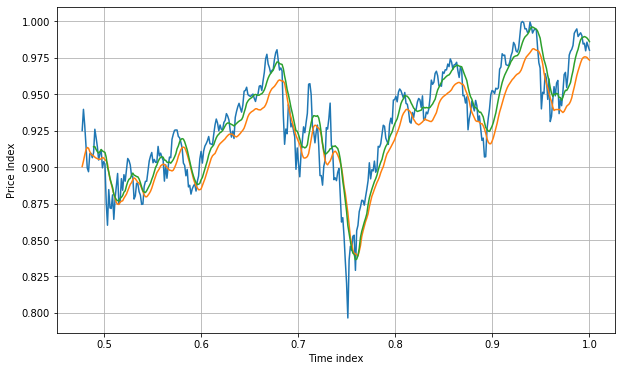

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
window=10
plot_series(time_valid[window-1:], moving_average(x_valid,window))

Looks very good. Now let's try to use the network on new stock data.

In [22]:
from keras.callbacks import ModelCheckpoint

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<0.008):
            print("\nReached reasonable accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=window_size, kernel_size=2,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256*window_size, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128*window_size, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)
])
model.load_weights("weights.second.hdf5")
optimizer = tf.keras.optimizers.SGD(lr=1*1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
# checkpoint

filepath="weights.second.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='mae', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]
history = model.fit(dataset,epochs=2,callbacks=callbacks_list)

Epoch 1/2
     45/Unknown - 146s 3s/step - loss: 7.8057e-05 - mae: 0.0057
Epoch 00001: saving model to weights.second.hdf5
45/45 [==============================] - 147s 3s/step - loss: 7.8057e-05 - mae: 0.0057
Epoch 2/2
44/45 [============================>.] - ETA: 3s - loss: 7.8883e-05 - mae: 0.0057
Epoch 00002: saving model to weights.second.hdf5
45/45 [==============================] - 143s 3s/step - loss: 7.7955e-05 - mae: 0.0057


In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

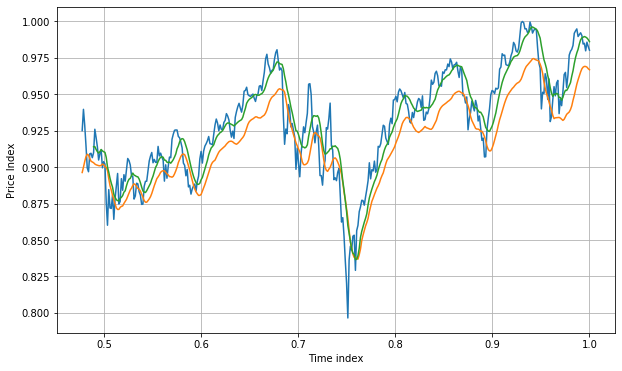

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
window=10
plot_series(time_valid[window-1:], moving_average(x_valid,window))